In [1]:
from scipy import sparse as sp

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

import numpy as np
import io
from os import path
from glob import glob
from tqdm import tqdm_notebook

from multiprocessing import Pool,cpu_count

from sklearn.base import clone as clone_estimator

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics.pairwise import paired_distances, paired_cosine_distances
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from collections import Counter

from random import shuffle
from itertools import repeat

from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def bla(X, models_):
    all_docs = sp.lil_matrix((X.shape[0], len(models_)*X.shape[1]))
    with Pool(processes=cpu_count()) as pool:
        lines = generate_lines(X)
        repeated_models = repeat(models_)
        for i, m in tqdm_notebook(enumerate(pool.imap(paired_di, zip(lines, repeated_models))), desc='Building representation', total=X.shape[0], smoothing=0.):
            all_docs[i,:] = m
    return all_docs

def generate_lines(X):
    for i in range(X.shape[0]):
        yield (X[i].multiply(X[i].T))
def paired_di(params):
    X, models_ = params
    m = sp.lil_matrix((1, len(models_)*X.shape[1]))
    for i, ci_dom in enumerate(models_):
        m[0,i*X.shape[1]:(i+1)*X.shape[1]] = paired_cosine_distances(ci_dom, X)
    return m.tocsr()
def _paired_distances_(params):
    X, model = params
    return sp.csr_matrix(paired_cosine_distances(model, X))
    
def transform_class_repr(X, model):
    all_docs = sp.lil_matrix(X.shape)
    with Pool(processes=cpu_count()) as pool:
        lines = generate_lines(X)
        repeated_model = repeat(model)
        params = zip(lines, repeated_model)
        for i, m in tqdm_notebook(enumerate(pool.imap(_paired_distances_, params)), desc='Building class transformation', total=X.shape[0], smoothing=0.):
            all_docs[i,:] = m
    return all_docs

class BoWS(BaseEstimator, TransformerMixin):
    def __init__(self, min_df=2, stop_words='english', alpha=0.1):
        self.min_df = min_df
        self.stop_words = stop_words
        self._cv = CountVectorizer(min_df=self.min_df, stop_words=self.stop_words)
        self._le = LabelEncoder()
        self.alpha = alpha
        self._fitted_ = False
        self.models_ = []
    def __del__(self):
        del self.models_[:]
    def fit(self, X_texts, y=None):
        if y is None:
            raise TypeError("y can't be None")
            
        a = list(zip(X_texts, y))
        shuffle(a)
        X_texts, scores = list(zip(*a))
        X_texts = list(X_texts)
        y = list(scores)
            
        X = self._build_binary_cooccur_matrix_(X_texts)
        y = self._normalize_y_(y)
        
        self._build_auxiliar_features(X, y)
        self._build_class_models_()
        
        del self.Ntc_
        del self.Nt_
        del self.Pt_
        
        self._fitted_ = True
        
        return self
    def transform(self, X_texts):
        if not self._fitted_:
            raise TypeError("The model did'nt fit yet!")
            
        X = self._cv.transform(X_texts)
        X_classes = {}
        for c in range(self.C_):
            X_classes[self._le.inverse_transform([c])[0]] = transform_class_repr(X, self.models_[c].copy())
        return X_classes
    def _build_binary_cooccur_matrix_(self, texts):
        X_TF = self._cv.fit_transform(texts).tocsr()    
        X = sp.csr_matrix( ( np.ones(len(X_TF.data)), X_TF.nonzero() ), shape=X_TF.shape )
        del X_TF
        return X
    def _normalize_y_(self, y):
        return self._le.fit_transform(y)
    def _build_auxiliar_features(self, X, y):
        # número de documentos
        self.N_ = X.shape[0]

        # tamanho do vocabulário
        self.V_ = X.shape[1] 

        # Número de classes
        self.C_ = max(y)+1

        # Número de cada co-ocrrência por classe
        self.Ntc_ = [ sp.lil_matrix( (self.V_,self.V_) ) for _ in range(max(y)+1) ]
        for i, doc_matrix in tqdm_notebook(enumerate(generate_lines(X)), total=self.N_, desc='Building class representations'):
            self.Ntc_[ y[i] ] = (self.Ntc_[ y[i] ] + doc_matrix)
        ### Remove diagonal principal
        for i in range(len(self.Ntc_)):
            self.Ntc_[i].setdiag(0)
            self.Ntc_[i].eliminate_zeros()
        
        # frequencia de cada co-ocorrência por classe
        self.Nt_ = np.sum(self.Ntc_)

        # priori de cada termo P(t)
        self.Pt_ = self.Nt_/self.N_
        self.Pt_.eliminate_zeros()
    def _build_class_models_(self):
        self.models_ = []
        for i in tqdm_notebook(range(self.C_), total=self.C_, desc='Building Models'):
            # Probabilidade P(t,c)
            data = np.array(self.Ntc_[i][ self.Nt_.nonzero() ] / self.Nt_[ self.Nt_.nonzero() ])[0]
            Ptc = sp.csr_matrix( (data, self.Nt_.nonzero()), shape=self.Nt_.shape )

            # Jenilek-Mercer smoothing
            norm_Ptc = (1.-self.alpha)*Ptc + self.alpha*self.Pt_

            # P*sqrt(n)
            data1 = np.multiply(norm_Ptc[norm_Ptc.nonzero()], np.sqrt(self.Ntc_[i][norm_Ptc.nonzero()]))
            # 2*sqrt( p(1-p) )
            data2 = 2.*np.sqrt(np.multiply(norm_Ptc[ norm_Ptc.nonzero() ], 1.-norm_Ptc[ norm_Ptc.nonzero() ]))

            CI_dominance_smooth = sp.csr_matrix( (np.array(data1/data2)[0], norm_Ptc.nonzero()), shape=norm_Ptc.shape )

            del data
            del data1
            del data2
            
            max_prob = (1.-self.alpha)*Ptc.data.max() + self.alpha*self.Pt_.data.max()
            max_size_ic = (max_prob*np.sqrt(self.Ntc_[i].data.max())) / (2.*np.sqrt( max_prob*(1.-max_prob) ))

            CI_dominance_smoooth_norm = CI_dominance_smooth / max_size_ic
            CI_dominance_smoooth_norm.eliminate_zeros()

            self.models_.append(CI_dominance_smoooth_norm)
            del CI_dominance_smooth
            del norm_Ptc
            del Ptc

In [3]:
def read_texts(filename):
    with io.open(filename, newline='\n') as filin:
        return filin.readlines()
def read_dataset(pathname):
    texts = read_texts(path.join(pathname, 'texts.txt'))
    scores = read_texts(path.join(pathname, 'score.txt'))
    scores = list(map(int, scores))
    return texts,scores

In [46]:
texts,scores = read_dataset('../../datasets/newsdatasets/sentiment/3Label/pang_movie/')

In [38]:
texts,scores = read_dataset('../../datasets/newsdatasets/sentiment/3Label/sentistrength_myspace/')

In [4]:
texts,scores = read_dataset('../../datasets/newsdatasets/sentiment/3Label/vader_nyt/')

In [17]:
texts,scores = read_dataset('../../datasets/newsdatasets/sentiment/3Label/vader_amazon/')

In [47]:
bows = BoWS()
X = bows.fit_transform(texts, scores)

In [48]:
X

{-1: <10662x9723 sparse matrix of type '<class 'numpy.float64'>'
 	with 88253710 stored elements in LInked List format>,
 1: <10662x9723 sparse matrix of type '<class 'numpy.float64'>'
 	with 88467018 stored elements in LInked List format>}

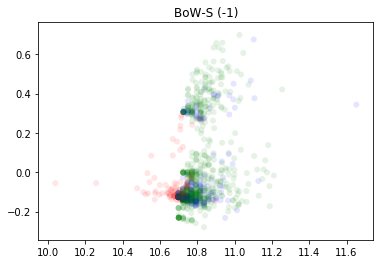

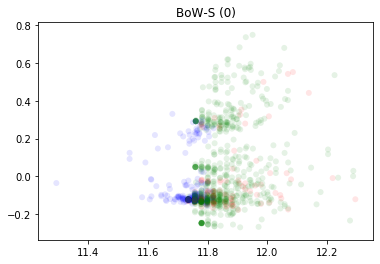

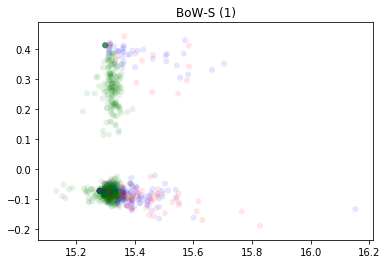

In [41]:
colors = { -1: 'red', 0: 'blue', 1: 'green' }
for c, X_class in X.items():
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_embedded = svd.fit_transform(X_class)
    plt.scatter(X_embedded[:,0], X_embedded[:,1], linewidth=0, c=[ colors[y_] for y_ in scores ], alpha=0.1)
    plt.title('BoW-S (%d)' % c)
    plt.show()

In [42]:
cv = CountVectorizer(min_df=2, stop_words='english')

X_TF = cv.fit_transform(texts).tocsr()
X_TFIDF = TfidfVectorizer(min_df=2, stop_words='english').fit_transform(texts).tocsr()

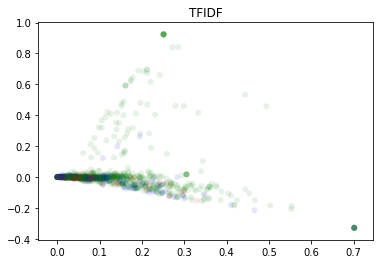

In [43]:
X_embedded = svd.fit_transform(X_TFIDF)
plt.scatter(X_embedded[:,0], X_embedded[:,1], linewidth=0, c=[ colors[y_] for y_ in scores ], alpha=0.1)
plt.title('TFIDF')
plt.show()

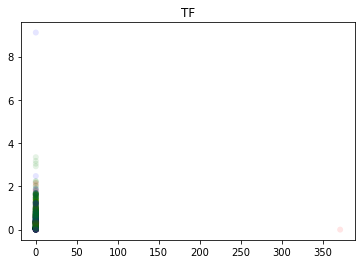

In [44]:
X_embedded = svd.fit_transform(X_TF)
plt.scatter(X_embedded[:,0], X_embedded[:,1], linewidth=0, c=[ colors[y_] for y_ in scores ], alpha=0.1)
plt.title('TF')
plt.show()

In [45]:
class OneVsAllGridClassifier(object):
    def __init__(self, weak_params, weak_classifier, meta_params, meta_classifier,
                 cv=5, n_jobs=12, scoring='f1_micro', iid=True):
        self.cv = cv
        self.n_jobs = n_jobs
        
        self.weak_clf = clone_estimator(weak_classifier)
        self.weak_params = weak_params
        self.weak_gs = GridSearchCV(self.weak_clf, self.weak_params, cv=self.cv, n_jobs=self.n_jobs, scoring=scoring, iid=iid)
        
        self.meta_clf = clone_estimator(meta_classifier)
        self.meta_params = meta_params
        self.meta_gs = GridSearchCV(self.meta_clf, self.meta_params, cv=self.cv, n_jobs=self.n_jobs, scoring=scoring, iid=iid)
        
        self.clf_by_class = {}
        self._fitted_ = False
        
    def fit(self, X_multiclass, y):
        self.classes_ = sorted( list(X_multiclass.keys()) )
        self.classes_mapper_ = { k:i for (i,k) in enumerate(self.classes_) }
        
        X_probs = []
        for c in self.classes_:
            X_class = X_multiclass[c]
            
            y_transformed = self.transform_y(y,c)
            self.weak_gs.fit(X_class, y_transformed)
            
            clf = clone_estimator(self.weak_clf).set_params(**self.weak_gs.best_params_)
            
            self.clf_by_class[c] = clf.fit(X_class, y_transformed)
            X_probs.append( clf.predict_proba( X_class )[:,1] )
            
        X_probs = np.matrix(X_probs).T
        self.meta_gs.fit(X_probs, y)
        self.meta_clf.set_params(**self.meta_gs.best_params_)
        self.meta_clf.fit(X_probs, y)
        
        self._fitted_ = True
        
        return self
    
    def predict(self, X_multiclass):
        if not self._fitted_ :
            raise Exception("Model did'nt fit.")
        X_probs = []
        for c in self.classes_:
            X_class = X_multiclass[c]
            X_probs.append( self.clf_by_class[c].predict_proba( X_class )[:,1] )
        
        y_pred = self.meta_clf.predict(np.matrix(X_probs).T)
        return y_pred
    
    def predict_proba_weak(self, X_multiclass):
        if not self._fitted_ :
            raise Exception("Model did'nt fit.")
        X_probs = []
        for c in self.classes_:
            X_class = X_multiclass[c]
            X_probs.append( self.clf_by_class[c].predict_proba( X_class )[:,1] )
        return np.matrix(X_probs).T
    def transform_y(self, y, c):
        return np.array([ a_ == c for a_ in y ], dtype=int)
    def fit_predict(self, X_multiclass, y):
        return self.fit(X_multiclass, y).predict(X_multiclass)

In [8]:
weak_clf = LogisticRegression(random_state=42, n_jobs=12)
#weak_params = {'penalty': ['l1', 'l2'], 'class_weight': ['balanced', None], 'solver': ['liblinear'], 'C': [1, 10, 0.1, 0.01]}
weak_params = {'penalty': ['l2'], 'class_weight': [None], 'solver': ['liblinear'], 'C': [0.01]}
meta_clf = DecisionTreeClassifier()
meta_params = { 'criterion': [ "gini", "entropy" ] }
oal = OneVsAllGridClassifier( weak_params, weak_clf, meta_params, meta_clf )
y_pred = oal.fit_predict(X, scores)

/home/mangaravite/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/home/mangaravite/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [17]:
from sklearn.metrics import f1_score

f1_score(scores, y_pred, average='micro')

0.9995310448321141

In [9]:
X_pred = oal.predict_proba_weak(X)

Text(0.5, 1.0, 'BoW-S')

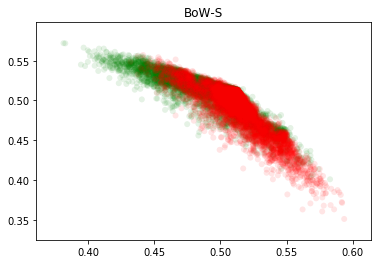

In [16]:
colors = { -1: 'red', 0: 'blue', 1: 'green' }

plt.scatter(np.array(X_pred[:,0].T)[0], np.array(X_pred[:,1].T)[0],
            linewidth=0, c=[ colors[y_] for y_ in scores ], alpha=0.1)
plt.title('BoW-S')

In [10]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


IndexError: index 2 is out of bounds for axis 1 with size 2

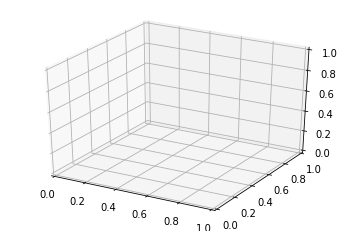

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter( np.array(X_pred[:,0].T)[0], np.array(X_pred[:,1].T)[0], np.array(X_pred[:,2].T)[0],
           alpha=0.1, linewidth=0, c=[ colors[y_] for y_ in scores ] )

In [183]:
from sklearn.manifold import TSNE

Text(0.5, 1.0, 'BoW-S')

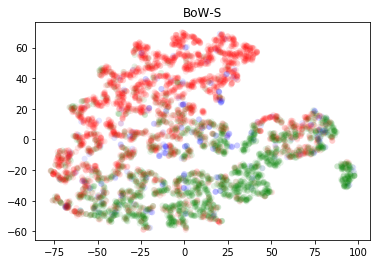

In [184]:
colors = { -1: 'red', 0: 'blue', 1: 'green' }
svd = TSNE(n_components=2, random_state=42)
X_embedded = svd.fit_transform(X_pred)
plt.scatter(X_embedded[:,0], X_embedded[:,1], linewidth=0, c=[ colors[y_] for y_ in scores ], alpha=0.1)
plt.title('BoW-S')

In [139]:
c = 0

clf = LogisticRegression(random_state=42, n_jobs=12)
clf.fit(X[c], np.array([ a_ == c for a_ in scores ], dtype=int))

/home/mangaravite/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/mangaravite/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=12, penalty='l2', random_state=42,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [115]:
y_pred = clf.predict_proba( X[c] )[:,1]
y_pred

array([0.02751242, 0.05906668, 0.05426068, ..., 0.02498895, 0.04248331,
       0.04453142])

In [116]:
y_pred.mean(), y_pred.max()

(0.046820230820016934, 0.13032804449573016)

In [8]:
colors = { -1: 'red', 0: 'blue', 1: 'green' }
for i in range(bows.C_):
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_embedded = svd.fit_transform(X[:,i*bows.V_:(i+1)*bows.V_])
    plt.scatter(X_embedded[:,0], X_embedded[:,1], linewidth=0, c=[ colors[y_] for y_ in scores ], alpha=0.1)
    plt.title('BoW-S (%d)' % bows._le.inverse_transform([i])[0])
    plt.show()
svd = TruncatedSVD(n_components=2, random_state=42)
X_embedded = svd.fit_transform(X)
plt.scatter(X_embedded[:,0], X_embedded[:,1], linewidth=0, c=[ colors[y_] for y_ in scores ], alpha=0.1)
plt.title('BoW-S')

NameError: name 'X' is not defined

In [ ]:
bows.get_params()

In [12]:
del bows

In [7]:
del X

NameError: name 'bows' is not defined

In [122]:
!ls ../../datasets/newsdatasets/sentiment/3Label/

aisopos_ntua	  sanders		 sentistrength_twitter	vader_nyt
debate		  sarcasm		 sentistrength_youtube	vader_twitter
english_dailabor  sentistrength_bbc	 stanford_tweets	yelp_reviews
irony		  sentistrength_digg	 tweet_semevaltest
nikolaos_ted	  sentistrength_myspace  vader_amazon
pang_movie	  sentistrength_rw	 vader_movie


In [123]:
texts,scores = read_dataset('../../datasets/newsdatasets/topics/reut/')

In [ ]:
texts,scores = read_dataset('../../datasets/newsdatasets/topics/webkb/')

In [56]:
texts,scores = read_dataset('../../datasets/newsdatasets/topics/20ng/')

In [67]:
texts,scores = read_dataset('../../datasets/newsdatasets/sentiment/3Label/irony/')

In [52]:
texts,scores = read_dataset('../../datasets/newsdatasets/sentiment/3Label/pang_movie/')

In [4]:
texts,scores = read_dataset('../../datasets/newsdatasets/sentiment/3Label/vader_nyt/')

In [7]:
texts,scores = read_dataset('../../datasets/newsdatasets/sentiment/3Label/vader_movie/')

In [8]:
a = list(zip(scores, texts, range(len(texts))))
shuffle(a)
scores, texts, idx_ = list(zip(*a))
texts = list(texts)
scores = list(scores)
len(texts)

10605

In [9]:
cv = CountVectorizer(min_df=2, stop_words='english')

X_TF = cv.fit_transform(texts).tocsr()
X_TFIDF = TfidfVectorizer(min_df=2, stop_words='english').fit_transform(texts).tocsr()

X = sp.csr_matrix( ( np.ones(len(X_TF.data)), X_TF.nonzero() ), shape=X_TF.shape )

In [10]:
le = LabelEncoder()
y = le.fit_transform(scores)
le.classes_

array([-1,  0,  1])

In [11]:
# número de documentos
N = X.shape[0]

# tamanho do vocabulário
V = X.shape[1] 

# Número de classes
C = max(y)+1

# Número de cada co-ocrrência por classe
Ntc = [ sp.lil_matrix( (V,V) ) for _ in range(max(y)+1) ]

# show dims
N,V

(10605, 9624)

In [12]:
for i in tqdm_notebook(range(N), total=N):
    co_sparse = (X[i].multiply(X[i].T))
    
    Ntc[ y[i] ] = (Ntc[ y[i] ] + co_sparse)

In [13]:
for i in tqdm_notebook(range(len(Ntc)), total=len(Ntc)):
    Ntc[i].setdiag(0)
    Ntc[i].eliminate_zeros()

/usr/local/lib/python3.6/dist-packages/scipy/sparse/compressed.py:708: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self[i, j] = values


In [14]:
alpha = 0.1

In [15]:
alpha = 0.1

# frequencia de documentos dos termos
df = X.sum(axis=0)

# número de documentos por classe
Nc = [ v for (k,v) in sorted(Counter(y).items(), key=lambda x: x[0]) ]

# frequencia de cada co-ocorrência por classe
Nt = np.sum(Ntc)

# priori de cada termo P(t)
Pt = Nt/N
Pt.eliminate_zeros()

In [16]:
CI_dom_all = []

for i in tqdm_notebook(range(len(Ntc)), total=len(Ntc)):
    # Probabilidade P(t,c)
    data = np.array(Ntc[i][ Nt.nonzero() ] / Nt[ Nt.nonzero() ])[0]
    Ptc = sp.csr_matrix( (data, Nt.nonzero()), shape=Nt.shape )

    # Jenilek-Mercer smoothing
    norm_Ptc = (1.-alpha)*Ptc + alpha*Pt
    
    # P*sqrt(n)
    data1 = np.multiply(norm_Ptc[norm_Ptc.nonzero()], np.sqrt(Ntc[i][norm_Ptc.nonzero()]))

    # 2*sqrt( p(1-p) )
    data2 = 2.*np.sqrt(np.multiply(norm_Ptc[ norm_Ptc.nonzero() ], 1.-norm_Ptc[ norm_Ptc.nonzero() ]))

    CI_dominance_smooth = sp.csr_matrix( (np.array(data1/data2)[0], norm_Ptc.nonzero()), shape=norm_Ptc.shape )
    
    max_prob = (1.-alpha)*Ptc.data.max() + alpha*Pt.data.max()
    #max_size_ic = (max_prob*np.sqrt(N)) / (2.*np.sqrt( max_prob*(1.-max_prob) ))
    max_size_ic = (max_prob*np.sqrt(Ntc[i].data.max())) / (2.*np.sqrt( max_prob*(1.-max_prob) ))
    
    CI_dominance_smoooth_norm = CI_dominance_smooth / max_size_ic
    CI_dominance_smoooth_norm.eliminate_zeros()
    
    del CI_dominance_smooth
    del norm_Ptc
    del Ptc
    
    CI_dom_all.append(CI_dominance_smoooth_norm)

In [17]:
def generate_lines(X):
    for i in range(X.shape[0]):
        mm = (X[i].multiply(X[i].T))
        yield mm
def paired_di(X):
    m = sp.lil_matrix((1, len(CI_dom_all)*X.shape[1]))
    for i, ci_dom in enumerate(CI_dom_all):
        m[0,i*V:(i+1)*V] = paired_cosine_distances(ci_dom, X)
    #m.resize(1,len(CI_dom_all)*X.shape[0])
    return m.tocsr()

In [18]:
(CI_dom_all[0] > CI_dom_all[1])

<9624x9624 sparse matrix of type '<class 'numpy.bool_'>'
	with 396518 stored elements in Compressed Sparse Row format>

In [19]:
all_docs = sp.lil_matrix((X.shape[0], len(CI_dom_all)*X.shape[1]))
with Pool(processes=cpu_count()) as pool:
    for i, m in tqdm_notebook(enumerate(pool.imap(paired_di, generate_lines(X))), total=X.shape[0], smoothing=0.):
        all_docs[i,:] = m

In [20]:
all_docs_csr = all_docs.tocsr()

array([-1,  1,  1, ...,  1, -1, -1])

In [21]:
paired_cosine_distances(CI_dom_all[0], CI_dom_all[1]).mean()

0.44392420560682644

In [22]:
AA = [0,0,0]
for i,j in [(0,1), (0,2), (1,2)]:
    mean = paired_cosine_distances(all_docs[i], all_docs[j]).mean()
    print(list(le.inverse_transform([i,j])), mean)
    AA[i] += mean
    AA[j] += mean
    

[-1, 0] 0.0010192894988108883
[-1, 1] 0.001150661757232727
[0, 1] 0.0011782480264920902


In [34]:
[ colors[y_] for y_ in le.inverse_transform(y) ]

['red',
 'green',
 'green',
 'red',
 'red',
 'red',
 'red',
 'green',
 'green',
 'red',
 'red',
 'green',
 'red',
 'red',
 'green',
 'red',
 'red',
 'green',
 'red',
 'red',
 'green',
 'red',
 'red',
 'green',
 'green',
 'green',
 'red',
 'green',
 'red',
 'green',
 'green',
 'red',
 'red',
 'green',
 'red',
 'red',
 'red',
 'red',
 'green',
 'red',
 'green',
 'red',
 'red',
 'red',
 'green',
 'red',
 'red',
 'red',
 'red',
 'green',
 'red',
 'green',
 'red',
 'red',
 'green',
 'red',
 'green',
 'green',
 'green',
 'green',
 'red',
 'red',
 'red',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'red',
 'green',
 'green',
 'green',
 'red',
 'red',
 'red',
 'green',
 'red',
 'red',
 'red',
 'green',
 'red',
 'red',
 'green',
 'red',
 'green',
 'green',
 'green',
 'red',
 'red',
 'green',
 'red',
 'green',
 'red',
 'green',
 'red',
 'red',
 'green',
 'green',
 'green',
 'red',
 'green',
 'red',
 'green',
 'green',
 'green',
 'green',
 'red',
 'red',
 'green',
 'green',
 'red'

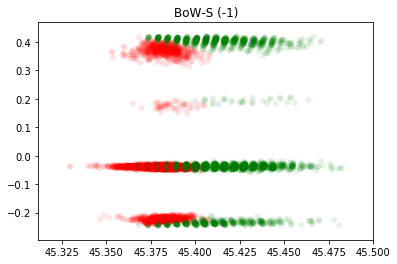

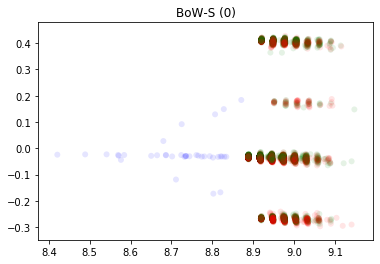

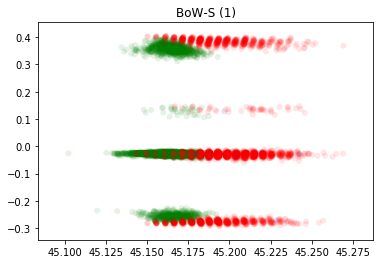

Text(0.5, 1.0, 'BoW-S')

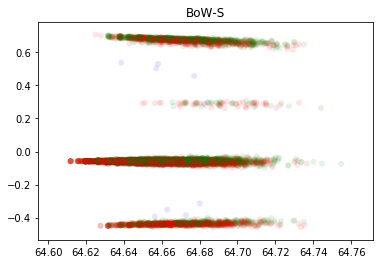

In [37]:
colors = { -1: 'red', 0: 'blue', 1: 'green' }
for i in range(C):
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_embedded = svd.fit_transform(all_docs[:,i*V:(i+1)*V])
    plt.scatter(X_embedded[:,0], X_embedded[:,1], linewidth=0, c=[ colors[y_] for y_ in le.inverse_transform(y) ], alpha=0.1)
    plt.title('BoW-S (%d)' % le.inverse_transform([i])[0])
    plt.show()
svd = TruncatedSVD(n_components=2, random_state=42)
X_embedded = svd.fit_transform(all_docs)
plt.scatter(X_embedded[:,0], X_embedded[:,1], linewidth=0, c=[ colors[y_] for y_ in le.inverse_transform(y) ], alpha=0.1)
plt.title('BoW-S')

In [ ]:
colors = { -1: 'red', 0: 'blue', 1: 'green' }

In [ ]:
svd = TruncatedSVD(n_components=2, random_state=42)
X_embedded = svd.fit_transform(all_docs_csr)
plt.scatter(X_embedded[:,0], X_embedded[:,1], linewidth=0, c=[ colors[le.inverse_transform([y_])[0]] for y_ in y ], alpha=0.1)
plt.title('BoW-S')

Text(0.5, 1.0, 'TF')

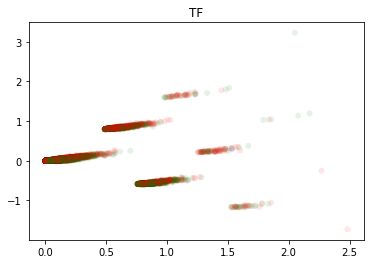

In [38]:
svd_2 = TruncatedSVD(n_components=2, random_state=42)
X_embedded_2 = svd_2.fit_transform(X_TF)
plt.scatter(X_embedded_2[:,0], X_embedded_2[:,1], linewidth=0, c=[ colors[le.inverse_transform([y_])[0]] for y_ in y ], alpha=0.1)
plt.title('TF')

Text(0.5, 1.0, 'TFIDF')

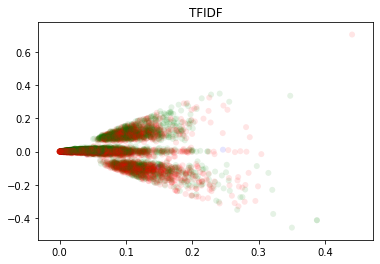

In [39]:
svd_2 = TruncatedSVD(n_components=2, random_state=42)
X_embedded_2 = svd_2.fit_transform(X_TFIDF)
plt.scatter(X_embedded_2[:,0], X_embedded_2[:,1], linewidth=0, c=[ colors[le.inverse_transform([y_])[0]] for y_ in y ], alpha=0.1)
plt.title('TFIDF')

Text(0.5, 1.0, '(0,1)')

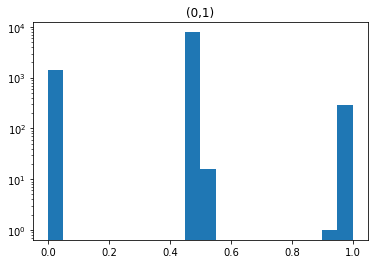

In [29]:
i = 1
j = 2
plt.hist(paired_cosine_distances(CI_dom_all[i], CI_dom_all[j]), bins=20, log='y')
plt.title( '(%d,%d)' % (le.inverse_transform([i])[0], le.inverse_transform([j])[0]) )

(array([1444.,    0.,    0.,    0., 7876.,   16.,    0.,    0.,    0.,
         288.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

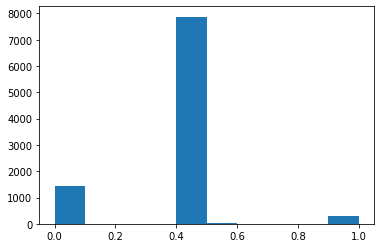

In [144]:
plt.hist(paired_cosine_distances(CI_dom_all[1], CI_dom_all[2]))

In [97]:
i = 0
# POR CLASSE

# priori da classe P(c)
Pc = Nc[i]/N

# priori da não-classe P(!c)
Pnc = (N-Nc[i]) / N

# Probabilidade P(t,c)
data = np.array(Ntc[i][ Nt.nonzero() ] / Nt[ Nt.nonzero() ])[0]
Ptc = sp.csr_matrix( (data, Nt.nonzero()), shape=Nt.shape )

# Jenilek-Mercer smoothing
norm_Ptc = (1.-alpha)*Ptc + alpha*Pt
norm_Ptc

<6424x6424 sparse matrix of type '<class 'numpy.float64'>'
	with 345254 stored elements in Compressed Sparse Row format>

In [98]:
# P*sqrt(n)
data1 = np.multiply(norm_Ptc[norm_Ptc.nonzero()], np.sqrt(Ntc[i][norm_Ptc.nonzero()]))

# 2*sqrt( p(1-p) )
data2 = 2.*np.sqrt(np.multiply(norm_Ptc[ norm_Ptc.nonzero() ], 1.-norm_Ptc[ norm_Ptc.nonzero() ]))

CI_dominance_smooth = sp.csr_matrix( (np.array(data1/data2)[0], norm_Ptc.nonzero()), shape=norm_Ptc.shape )
CI_dominance_smooth

<6424x6424 sparse matrix of type '<class 'numpy.float64'>'
	with 345254 stored elements in Compressed Sparse Row format>

In [99]:
CI_dominance_smooth.data.max(), CI_dominance_smooth.data.min()

(5.202838159417788, 0.0)

In [100]:
max_prob = (1.-alpha)*Ptc.data.max() + alpha*Pt.data.max()
#max_size_ic = (max_prob*np.sqrt(N)) / (2.*np.sqrt( max_prob*(1.-max_prob) ))
max_size_ic = (max_prob*np.sqrt(Ntc[i].data.max())) / (2.*np.sqrt( max_prob*(1.-max_prob) ))
max_size_ic

17.48619258316463

In [101]:
CI_dominance_smoooth_norm = CI_dominance_smooth / max_size_ic
CI_dominance_smoooth_norm.data.max()

0.2975397951654141

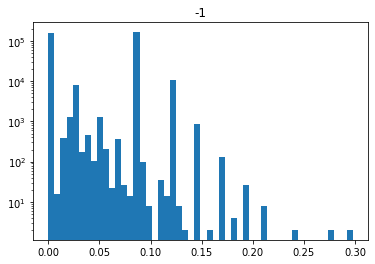

In [107]:
h = plt.hist(CI_dominance_smoooth_norm.data, bins=50, log='y')
tt = plt.title(le.inverse_transform([i])[0])

In [94]:
x = CI_dominance_smoooth_norm[CI_dominance_smoooth_norm.nonzero()].argmax()

In [104]:
x_coord, y_coord = CI_dominance_smoooth_norm.nonzero()
cv.get_feature_names()[x_coord[x]], cv.get_feature_names()[y_coord[x]]

('000', '30')

In [103]:
CI_dominance_smoooth_norm[x_coord[x], y_coord[x]]

0.0

In [53]:
def entropy(M):
    data = np.array(np.log2(M[M.nonzero()]))[0]
    log_prob = sp.csr_matrix( (data, M.nonzero()), shape=M.shape )
    return M.multiply(log_prob)

In [12]:
entropy(Pt)

<26343x26343 sparse matrix of type '<class 'numpy.float64'>'
	with 102061517 stored elements in Compressed Sparse Row format>

In [13]:
entropy(Ptc)

<26343x26343 sparse matrix of type '<class 'numpy.float64'>'
	with 6437175 stored elements in Compressed Sparse Row format>

In [14]:
len(Nc)

7